In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
sum(p.nelement() for p in parameters)

11897

In [8]:
for p in parameters:
    p.requires_grad = True

In [9]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [10]:
lri = []
lossi = []
stepi = []

In [11]:
# training set

for i in range(200000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.8598506450653076


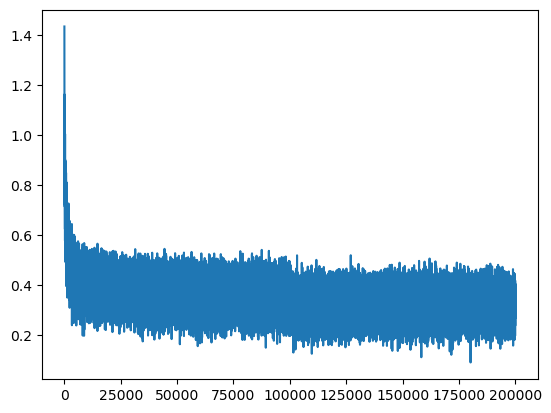

In [12]:
plt.plot(stepi, lossi)

In [13]:
# dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1664, grad_fn=<NllLossBackward0>)

In [14]:
# test set
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1583, grad_fn=<NllLossBackward0>)

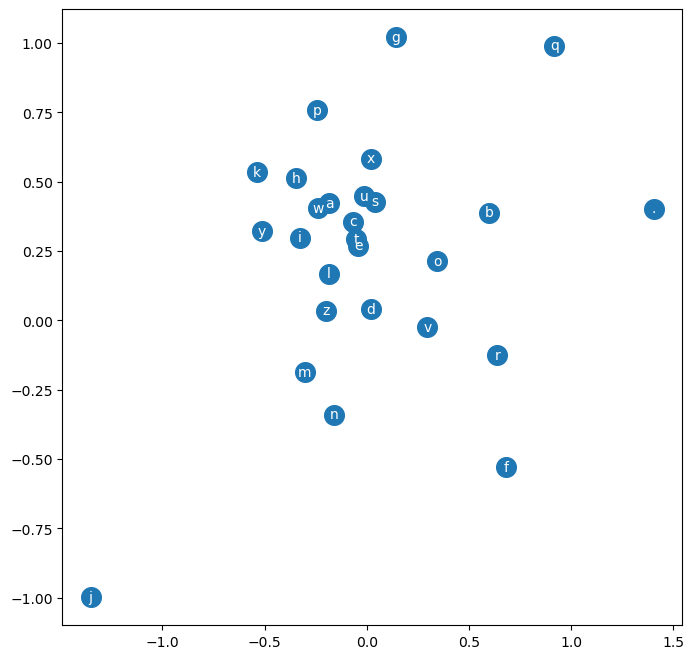

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")

In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amori.
kitzimrix.
thiyah.
cassa.
jazonton.
merric.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
joir.
quintis.
lilea.
jadiquinathonderryn.
kai.
evidrudi.
edde.
oia.
